# turbpy package for simulating sensible and latent heat fluxes
- Provide boundary conditions to specified stability functions
- Allows direct testing of turbulence stability schemes

In [2]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# -------------------------------------------------------------------------------------------------------
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xray
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('poster')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# -------------------------------------------------------------------------------------------------------
# Custom packages
import solargeo
import kgraph
import turbpy
import turbpy.multiConst as mc

# -------------------------------------------------------------------------------------------------------
# Directory Lists
# -------------------------------------------------------------------------------------------------------
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'  # Project directory
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures

### Check behavior of stability functions


In [28]:
ixStability = ('standard', 'louisInversePower', 'mahrtExponential', 'moninObukhov')
ixStabilityTitles = ('Anderson', 'Louis', 'Mahrt', 'Monin-Obukhov', 'Monin-Obukhov (no cap)')

# Dictionary of colors
colr = np.append(kgraph.SRON(4), sns.color_palette(["#9b59b6"]), axis=0)
colr = dict(zip(ixStabilityTitles, colr))

# Met variables
sfcTemp = 265
airTemp = np.arange(243, 295)
windspd = 1.
mHeight = 2.
z0Ground = .005
snowDepth = 0.
scalarGroundSnowFraction  = 1.
(airVaporPress, _) = turbpy.satVapPress(airTemp - 273.)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.)
airPressure = 101000.

RiBulk,_,_ = turbpy.bulkRichardson(airTemp, sfcTemp, windspd, mHeight)

## Test Stability Functions

In [29]:
## Calculate stability
stabilitySchemes = {
    ixStabilityTitles[0]:np.zeros_like(RiBulk),
    ixStabilityTitles[1]:np.zeros_like(RiBulk),
    ixStabilityTitles[2]:np.zeros_like(RiBulk),
    ixStabilityTitles[3]:np.zeros_like(RiBulk),
    }
conductanceSensible = {
    ixStabilityTitles[0]:np.zeros_like(RiBulk),
    ixStabilityTitles[1]:np.zeros_like(RiBulk),
    ixStabilityTitles[2]:np.zeros_like(RiBulk),
    ixStabilityTitles[3]:np.zeros_like(RiBulk),
    }
senHeatGround = {
    ixStabilityTitles[0]: np.zeros_like(RiBulk),
    ixStabilityTitles[1]: np.zeros_like(RiBulk),
    ixStabilityTitles[2]: np.zeros_like(RiBulk),
    ixStabilityTitles[3]: np.zeros_like(RiBulk),
    }

## Calculate stability
for stab, stabTitle in zip(ixStability, ixStabilityTitles):
    for n, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):
        # Check for MO capping
        if 'no cap' in stabTitle:
            windlessExchange = False
        else:
            windlessExchange = True

        # Offline Turbulence Package
        (conductanceSensible[stabTitle][n], _, senHeatGround[stabTitle][n], _, _, stabOutput, _, _) \
            = turbpy.turbFluxes(tair, airPressure, vp, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                                groundSnowFraction=1,
                                ixDerivMethod=False,
                                ixStability=stab,
                                ixStabParam=mc.stabParams[stab],
                                z0Ground=.005,
                                windlessExchange=windlessExchange)
        
        # Unpack stability parameters dictionary
        if not 'moninObukhov' in stab:
            stabilitySchemes[stabTitle][n] = stabOutput['stabilityCorrection']
        else:
            stabilitySchemes[stabTitle][n] = np.nan

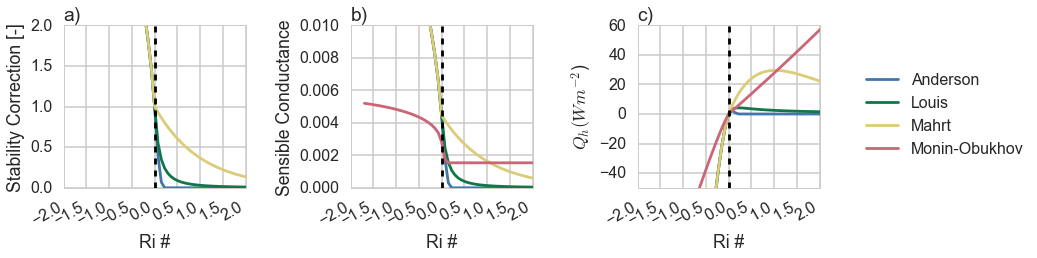

In [31]:
# Figure
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
axes = axes.flatten()

# Plotting parameters
Qmax = 60
Qmin = -50
RiMax = 2
RiMin = -2

# a) Stability correction
ax = axes[0]
for stab, stabTitle in zip(ixStability, ixStabilityTitles):
    ax.plot(RiBulk, stabilitySchemes[stabTitle], color=colr[stabTitle])
ax.plot([0, 0],[0, 4], 'k--')
ax.set_xlim(RiMin, RiMax)
ax.set_ylim(0, 2)
ax.set_ylabel('Stability Correction [-]')
ax.set_xlabel('Ri #')
ax.set_title('a)', loc='left')

# b) Conductance
ax = axes[1]
for stab, stabTitle in zip(ixStability, ixStabilityTitles):
    ax.plot(RiBulk, conductanceSensible[stabTitle], color=colr[stabTitle])
ax.plot([0, 0], [0., 0.1], 'k--')
ax.set_ylim(0,0.01)
ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('b)', loc='left')

# c) Sensible Heat Flux

# Bulk Richardson number
RiBulk,_,_ = turbpy.bulkRichardson(airTemp,sfcTemp,windspd,mHeight)
ax = axes[2]

for stab, stabTitle in zip(ixStability, ixStabilityTitles):
    ax.plot(RiBulk, senHeatGround[stabTitle], color=colr[stabTitle], label=stabTitle)
ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('c)', loc='left')
lgd = ax.legend(bbox_to_anchor=(2.2, .8))

fig.tight_layout()
fig.autofmt_xdate()
os.chdir(dirPrint)
fig.savefig('TF.OfflineTurb.Idealized.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('TF.OfflineTurb.Idealized.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

Example of the stability functions available in the turbpy package.

a) The stability corrections for the bulk aerodynamic methods

b) the conductance for all methods

c) the resulting sensible heat fluxes for each method assuming a surface temperature of 265K, wind speed of 1 m/s, 
surface roughness of 0.005, and varying the air temperature from 253K (Ri = -1) to 293K (Ri = 2).


## Test effect of MO capping

In [25]:
ixStabilityCapping = ('standard', 'louisInversePower', 'mahrtExponential', 'moninObukhov', 'moninObukhov')
ixStabilityCappingTitles = ('Anderson', 'Louis', 'Mahrt', 'Monin-Obukhov', 'Monin-Obukhov (no cap)')

stabilitySchemes = {
    ixStabilityCappingTitles[0]: np.zeros_like(RiBulk),
    ixStabilityCappingTitles[1]: np.zeros_like(RiBulk),
    ixStabilityCappingTitles[2]: np.zeros_like(RiBulk),
    ixStabilityCappingTitles[3]: np.zeros_like(RiBulk),
    ixStabilityCappingTitles[4]: np.zeros_like(RiBulk),
    }
conductanceSensible = {
    ixStabilityCappingTitles[0]: np.zeros_like(RiBulk),
    ixStabilityCappingTitles[1]: np.zeros_like(RiBulk),
    ixStabilityCappingTitles[2]: np.zeros_like(RiBulk),
    ixStabilityCappingTitles[3]: np.zeros_like(RiBulk),
    ixStabilityCappingTitles[4]: np.zeros_like(RiBulk),
    }
senHeatGround = {
    ixStabilityCappingTitles[0]: np.zeros_like(RiBulk),
    ixStabilityCappingTitles[1]: np.zeros_like(RiBulk),
    ixStabilityCappingTitles[2]: np.zeros_like(RiBulk),
    ixStabilityCappingTitles[3]: np.zeros_like(RiBulk),
    ixStabilityCappingTitles[4]: np.zeros_like(RiBulk),
    }

## Calculate stability
for stab, stabTitle in zip(ixStabilityCapping, ixStabilityCappingTitles):
    for n, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):
        # Check for MO capping
        if 'no cap' in stabTitle:
            windlessExchange = False
        else:
            windlessExchange = True

        # Offline Turbulence Package
        (conductanceSensible[stabTitle][n], _, senHeatGround[stabTitle][n], _, _, stabOutput, _, _) \
            = turbpy.turbFluxes(tair, airPressure, vp, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                                groundSnowFraction=1,
                                ixDerivMethod=False,
                                ixStability=stab,
                                ixStabParam=mc.stabParams[stab],
                                z0Ground=.005,
                                windlessExchange=windlessExchange)
        
        # Unpack stability parameters dictionary
        if not 'moninObukhov' in stab:
            stabilitySchemes[stabTitle][n] = stabOutput['stabilityCorrection']
        else:
            stabilitySchemes[stabTitle][n] = np.nan

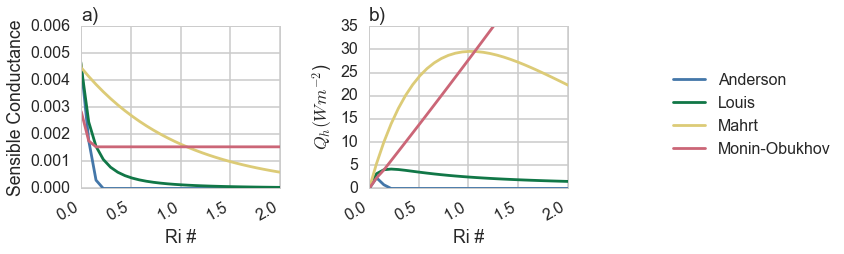

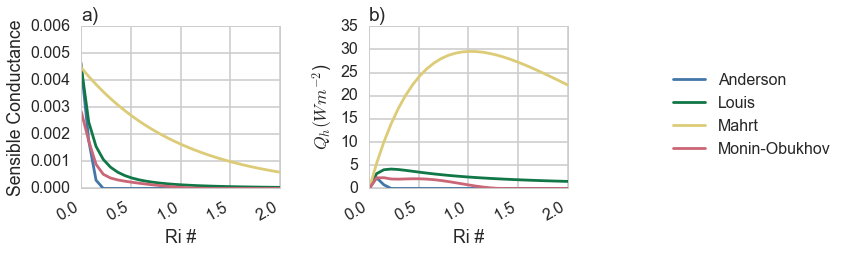

In [26]:
colr = kgraph.SRON(4)
colr = dict(zip(ixStabilityTitles, colr))

# -------------------------------------------------------------------------------------------------------
# With cap
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.5))
axes = axes.flatten()

# Plotting parameters
Qmax = 35
Qmin = 0
RiMax = 2
RiMin = 0

# a) Conductance
ax = axes[0]
for stab, stabTitle in zip(ixStabilityCapping, ixStabilityCappingTitles):
    if 'no cap' in stabTitle:
        continue
    ax.plot(RiBulk, conductanceSensible[stabTitle],
            label=stabTitle, color=colr[stabTitle])
ax.set_ylim(0,0.006)
ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('a)', loc='left')

# b) Sensible Heat Flux
# Bulk Richardson number
RiBulk,_,_ = turbpy.bulkRichardson(airTemp,sfcTemp,windspd,mHeight)
ax = axes[1]

for stab, stabTitle in zip(ixStabilityCapping, ixStabilityCappingTitles):
    if 'no cap' in stabTitle:
        continue
    ax.plot(RiBulk, senHeatGround[stabTitle],
            label=stabTitle, color=colr[stabTitle])
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b)', loc='left')
lgd = ax.legend(bbox_to_anchor=(2.4, .8))

# Final Formatting
fig.tight_layout()
fig.autofmt_xdate()
os.chdir(dirPrint)
fig.savefig('TF.OfflineTurb.MOCapping.Idealized.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('TF.OfflineTurb.MOCapping.Idealized.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

# -------------------------------------------------------------------------------------------------------
# Withour cap
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.5))
axes = axes.flatten()

# Plotting parameters
Qmax = 35
Qmin = 0
RiMax = 2
RiMin = 0

# a) Conductance
ax = axes[0]
for stab, stabTitle in zip(ixStabilityCapping, ixStabilityCappingTitles):
    if 'Monin-Obukhov' in stabTitle:
        if 'no cap' in stabTitle:
            stabTitle_colrLeg = 'Monin-Obukhov'
        else:
            continue
    else:
        stabTitle_colrLeg = stabTitle
    ax.plot(RiBulk, conductanceSensible[stabTitle],
            label=stabTitle_colrLeg, color=colr[stabTitle_colrLeg])
ax.set_ylim(0,0.006)
ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('a)', loc='left')

# b) Sensible Heat Flux
# Bulk Richardson number
RiBulk,_,_ = turbpy.bulkRichardson(airTemp,sfcTemp,windspd,mHeight)
ax = axes[1]

for stab, stabTitle in zip(ixStabilityCapping, ixStabilityCappingTitles):
    if 'Monin-Obukhov' in stabTitle:
        if 'no cap' in stabTitle:
            stabTitle_colrLeg = 'Monin-Obukhov'
        else:
            continue
    else:
        stabTitle_colrLeg = stabTitle
    ax.plot(RiBulk, senHeatGround[stabTitle],
            color=colr[stabTitle_colrLeg], label=stabTitle_colrLeg)
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b)', loc='left')
lgd = ax.legend(bbox_to_anchor=(2.4, .8))

# Final Formatting
fig.tight_layout()
fig.autofmt_xdate()
os.chdir(dirPrint)
fig.savefig('TF.OfflineTurb.NoCapping.Idealized.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('TF.OfflineTurb.NoCapping.Idealized.png', bbox_extra_artists=(lgd,), bbox_inches='tight')


## Testing the effects of the critical Richardson Number in the Anderson stability correction

In [7]:
ixStabilityCritical = ('standard', 'standard', 'moninObukhov', 'moninObukhov')
ixStabilityCriticalTitles = ('Anderson','Anderson adj.', 'Monin-Obukhov', 'Monin-Obukhov (no cap)')

colr = sns.color_palette('muted')
colr = dict(zip(ixStabilityCriticalTitles, colr[0:4]))

stabilitySchemes = {
    ixStabilityCriticalTitles[0]: np.zeros_like(RiBulk),
    ixStabilityCriticalTitles[1]: np.zeros_like(RiBulk),
    ixStabilityCriticalTitles[2]: np.zeros_like(RiBulk),
    ixStabilityCriticalTitles[3]: np.zeros_like(RiBulk),
    }
conductanceSensible = {
    ixStabilityCriticalTitles[0]: np.zeros_like(RiBulk),
    ixStabilityCriticalTitles[1]: np.zeros_like(RiBulk),
    ixStabilityCriticalTitles[2]: np.zeros_like(RiBulk),
    ixStabilityCriticalTitles[3]: np.zeros_like(RiBulk),
    }
senHeatGround = {
    ixStabilityCriticalTitles[0]: np.zeros_like(RiBulk),
    ixStabilityCriticalTitles[1]: np.zeros_like(RiBulk),
    ixStabilityCriticalTitles[2]: np.zeros_like(RiBulk),
    ixStabilityCriticalTitles[3]: np.zeros_like(RiBulk),
    }

paramValues = mc.stabParams

## Calculate stability
for stab, stabTitle in zip(ixStabilityCritical, ixStabilityCriticalTitles):
    for n, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):
        # Check for MO capping
        if 'no cap' in stabTitle:
            windlessExchange = False
        else:
            windlessExchange = True

        # Check for critical Ri change
        if 'adj.' in stabTitle:
            paramValues['standard'] = 1.4
        else:
            paramValues['standard'] = 0.2
            
        # Offline Turbulence Package
        (conductanceSensible[stabTitle][n], _, senHeatGround[stabTitle][n], _, _, stabOutput, _, _) \
            = turbpy.turbFluxes(tair, airPressure, vp, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                                groundSnowFraction=1,
                                ixDerivMethod=False,
                                ixStability=stab,
                                ixStabParam=paramValues[stab],
                                z0Ground=.005,
                                windlessExchange=windlessExchange)
        
        # Unpack stability parameters dictionary
        if not 'moninObukhov' in stab:
            stabilitySchemes[stabTitle][n] = stabOutput['stabilityCorrection']
        else:
            stabilitySchemes[stabTitle][n] = np.nan

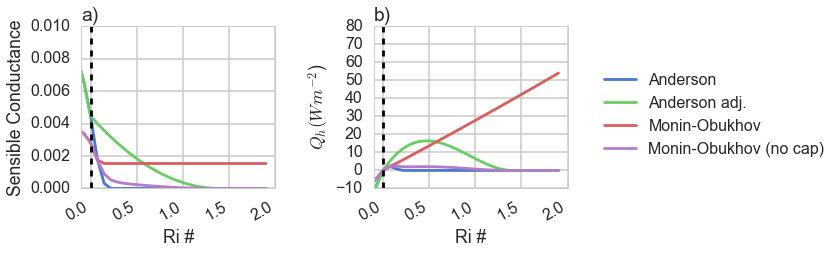

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.5))
axes = axes.flatten()

Qmax = 80
Qmin = -10
RiMax = 2
RiMin = -0.1

# b) Conductance
ax = axes[0]
for stab, stabTitle in zip(ixStabilityCritical, ixStabilityCriticalTitles):
    ax.plot(RiBulk, conductanceSensible[stabTitle],
            label=stabTitle, color=colr[stabTitle])
ax.plot([0, 0], [0., 0.02], 'k--')
ax.set_ylim(0,0.01)
ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('a)', loc='left')

# c) Sensible Heat Flux
# Plotting parameters


# Bulk Richardson number
RiBulk,_,_ = turbpy.bulkRichardson(airTemp,sfcTemp,windspd,mHeight)
ax = axes[1]

for stab, stabTitle in zip(ixStabilityCritical, ixStabilityCriticalTitles):
    ax.plot(RiBulk, senHeatGround[stabTitle],
            color=colr[stabTitle], label=stabTitle)
ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b)', loc='left')
lgd = ax.legend(bbox_to_anchor=(2.4, .8))

# Final Formatting
fig.tight_layout()
fig.autofmt_xdate()
os.chdir(dirPrint)
fig.savefig('TF.OfflineTurb.AndersonRiCrit.Idealized.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('TF.OfflineTurb.AndersonRiCrit.Idealized.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

Had to change the expression of the Anderson stability scheme so that it appropriately decayed away to zero. Otherwise it would exponentially grow past Ri=0.2. Clearly the coefficients were chosen to satisfy that behavior.

## Testing how varying $z_0$ affects the schemes

In [26]:
ixStabilityZ0 = ('standard', 'standard', 'standard',
                 'moninObukhov', 'moninObukhov', 'moninObukhov', 'moninObukhov')
ixStabilityZ0Titles = ('Anderson','Anderson (z0 big)', 'Anderson (z0 small)',
                       'Monin-Obukhov', 'Monin-Obukhov (z0 big)', 'Monin-Obukhov (z0 small)')

colr = np.append(sns.color_palette('Blues_d', 3), sns.color_palette('Purples_d', 4), axis=0)
colr = dict(zip(ixStabilityZ0Titles, colr))

# The below doesn't work. All the entries end up with the same values.
# stabilitySchemes = dict(zip(ixStabilityZ0Titles, [np.zeros_like(RiBulk)] * len(ixStabilityZ0Titles)))
# conductanceSensible = dict(zip(ixStabilityZ0Titles, [np.zeros_like(RiBulk)] * len(ixStabilityZ0Titles)))
# senHeatGround = dict(zip(ixStabilityZ0Titles, [np.zeros_like(RiBulk)] * len(ixStabilityZ0Titles)))

stabilitySchemes = {
    ixStabilityZ0Titles[0]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[1]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[2]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[3]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[4]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[5]: np.zeros_like(RiBulk),
    }
conductanceSensible = {
    ixStabilityZ0Titles[0]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[1]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[2]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[3]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[4]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[5]: np.zeros_like(RiBulk),
    }
senHeatGround = {
    ixStabilityZ0Titles[0]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[1]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[2]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[3]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[4]: np.zeros_like(RiBulk),
    ixStabilityZ0Titles[5]: np.zeros_like(RiBulk),
    }

## Calculate stability
for stab, stabTitle in zip(ixStabilityZ0, ixStabilityZ0Titles):
    for n, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):
        # Check for MO capping
        if 'no cap' in stabTitle:
            windlessExchange = False
        else:
            windlessExchange = True

        # Check for zo parameter
        if 'big' in stabTitle:
            z0 = 0.05
        elif 'small' in stabTitle:
            z0 = 0.0005
        else:
            z0 = 0.005

        # Offline Turbulence Package
        (conductanceSensible[stabTitle][n], _, senHeatGround[stabTitle][n], _, _, stabOutput, _, _) \
            = turbpy.turbFluxes(tair, airPressure, vp, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                                groundSnowFraction=1,
                                ixDerivMethod=False,
                                ixStability=stab,
                                ixStabParam=mc.stabParams[stab],
                                z0Ground=z0,
                                windlessExchange=windlessExchange)
        
        # Unpack stability parameters dictionary
        if not 'moninObukhov' in stab:
            stabilitySchemes[stabTitle][n] = stabOutput['stabilityCorrection']
        else:
            stabilitySchemes[stabTitle][n] = np.nan

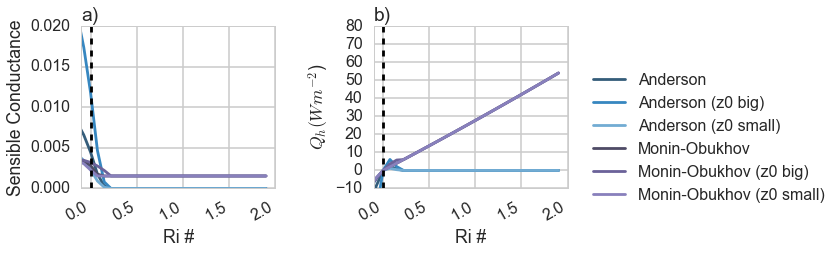

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.5))
axes = axes.flatten()

Qmax = 80
Qmin = -10
RiMax = 2
RiMin = -0.1

# b) Conductance
ax = axes[0]
for stab, stabTitle in zip(ixStabilityZ0, ixStabilityZ0Titles):
    ax.plot(RiBulk, conductanceSensible[stabTitle],
            label=stabTitle, color=colr[stabTitle])
ax.plot([0, 0], [0., 0.02], 'k--')
ax.set_ylim(0,0.02)
ax.set_xlim(RiMin, RiMax)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('a)', loc='left')

# c) Sensible Heat Flux
# Plotting parameters


# Bulk Richardson number
RiBulk,_,_ = turbpy.bulkRichardson(airTemp,sfcTemp,windspd,mHeight)
ax = axes[1]

for stab, stabTitle in zip(ixStabilityZ0, ixStabilityZ0Titles):
    ax.plot(RiBulk, senHeatGround[stabTitle],
            color=colr[stabTitle], label=stabTitle)
ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('b)', loc='left')
lgd = ax.legend(bbox_to_anchor=(2.4, .8))

# Final Formatting
fig.tight_layout()
fig.autofmt_xdate()
os.chdir(dirPrint)
fig.savefig('TF.OfflineTurb.varyZ0.Idealized.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('TF.OfflineTurb.vzryZ0.Idealized.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

Largely unaffected by z0 term except for near neutral stability.

## Parameter space of z0 - RiCrit in Anderson 1976

//anaconda/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:975: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=1,1 nx,ny=4,7 m=13 fp=0.427835 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
//anaconda/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:975: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=13 fp=0.080656 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
//anaconda/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:975: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp

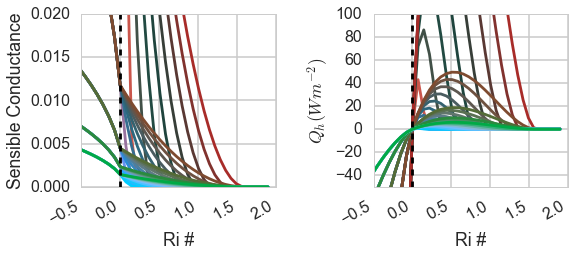

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(8.5, 3.5))
axes = axes.flatten()
ixStability = 'standard'

# Turbulence parameters
z0Ground = [.5, .05, .005, .0005, .00005]
RiCrit = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]
paramValues = mc.stabParams

# 2D color space
colr1 = sns.color_palette('Blues_d', np.size(z0Ground))
colr2 = sns.color_palette('Reds_d', np.size(RiCrit))

x = np.append(np.arange(0, np.size(z0Ground)), np.zeros(np.size(RiCrit)))
y = np.append(np.arange(0, np.size(RiCrit)), np.zeros(np.size(z0Ground)))
xx, yy = np.meshgrid(x, y)

z1 = np.append(np.matrix(colr1)[:, 0], np.matrix(colr2)[:, 0], axis=0)
z2 = np.append(np.matrix(colr1)[:, 1], np.matrix(colr2)[:, 1], axis=0)
z3 = np.append(np.matrix(colr1)[:, 2], np.matrix(colr2)[:, 2], axis=0)

f1 = interpolate.interp2d(x, y, z1, kind='linear')
f2 = interpolate.interp2d(x, y, z2, kind='linear')
f3 = interpolate.interp2d(x, y, z3, kind='linear')

x = np.arange(0, np.size(z0Ground))
y = np.arange(0, np.size(RiCrit))

colrSpace1 = f1(x, y)
colrSpace1[colrSpace1 > 1] = 1
colrSpace2 = f2(x, y)
colrSpace2[colrSpace2 > 1] = 1
colrSpace3 = f3(x, y)
colrSpace3[colrSpace3 > 1] = 1

stabilitySchemes = np.zeros_like(RiBulk)
conductanceSensible = np.zeros_like(RiBulk)
senHeatGround = np.zeros_like(RiBulk)

## Calculate stability
for nz, z0 in enumerate(z0Ground):
    for nr, RiC in enumerate(RiCrit):
        for n, (tair, vp) in enumerate(zip(airTemp, airVaporPress)):
            paramValues[ixStability] = RiC
            # Offline Turbulence Package
            (conductanceSensible[n], _, senHeatGround[n], _, _, stabOutput, _, _) \
                = turbpy.turbFluxes(tair, airPressure, vp, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
                                    groundSnowFraction=1,
                                    ixDerivMethod=False,
                                    ixStability=ixStability,
                                    ixStabParam=paramValues[ixStability],
                                    z0Ground=z0)
        colrSpace = (colrSpace1[nr, nz], colrSpace2[nr, nz], colrSpace3[nr, nz])
        ax = axes[0]
        ax.plot(RiBulk, conductanceSensible, color=colrSpace)
        ax.set_ylim(0,0.02)
        ax.set_xlim(-.5, 2)
        ax.set_ylabel('Sensible Conductance')
        ax.set_xlabel('Ri #')

        ax = axes[1]
        ax.plot(RiBulk, senHeatGround, color=colrSpace)
        ax.set_ylim(-50, 100)
        ax.set_xlim(-.5, 2)
        ax.set_ylabel('$Q_h (Wm^{-2})$')
        ax.set_xlabel('Ri #')

axes[0].plot([0, 0], [0., 0.02], 'k--')      
axes[1].plot([0, 0], [-50, 100], 'k--')
# Final Formatting
fig.tight_layout()
fig.autofmt_xdate()
os.chdir(dirPrint)
fig.savefig('TF.OfflineTurb.Anderson.ParamSpace.pdf', bbox_inches='tight')
fig.savefig('TF.OfflineTurb.Anderson.ParamSpace.png', bbox_inches='tight')